In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import nltk   
import matplotlib.pyplot as plt           
import random 
from collections import Counter 
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm

import os
import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import word_tokenize   # module for tokenizing strings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [3]:
DATA_DIR = '../input/anime-quotes/'

In [4]:
LEX_DIR = '../input/bing-nrc-afinn-lexicons/'

In [5]:
train_df = pd.read_csv(DATA_DIR+'AnimeQuotes.csv')
train_df.head()

,Quote,Character,Anime
0,"People’s lives don’t end when they die, it end...",Itachi Uchiha,Naruto
1,"If you don’t take risks, you can’t create a fu...",Monkey D Luffy,One Piece
2,"If you don’t like your destiny, don’t accept it.",Naruto Uzumaki,Naruto
3,"When you give up, that’s when the game ends.",Mitsuyoshi Anzai,Slam Dunk
4,All we can do is live until the day we die. Co...,Deneil Young,Uchuu Kyoudai or Space Brothers


# Group by names

In [6]:
df_names = train_df.groupby('Character', as_index=False).agg(lambda x:' '.join(x))
df_names

/opt/conda/lib/python3.7/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)


,Character,Quote
0,Akame,"If you can’t find a reason to fight, then you ..."
1,Alibaba Saluja,If nobody cares to accept you and wants you in...
2,Allen Walker,"When you lose sight of your path, listen for t..."
3,Alucard,Giving up kills people. When people reject giv...
4,Archer,It is at the moment of death that humanity has...
...,...,...
89,Yato,Life and death are like light and shadow. They...
90,Ymir,You re Gonna Care What Other People Think And ...
91,Yuu Nishinoya,Life s a bore if you don t challenge yourself
92,Yuuji Kazami,Life comes at a cost. Wouldn’t it be arrogant ...


In [7]:
df_names.loc[df_names['Character']=='Akame','Quote']

0    If you can’t find a reason to fight, then you ...
Name: Quote, dtype: object

In [8]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

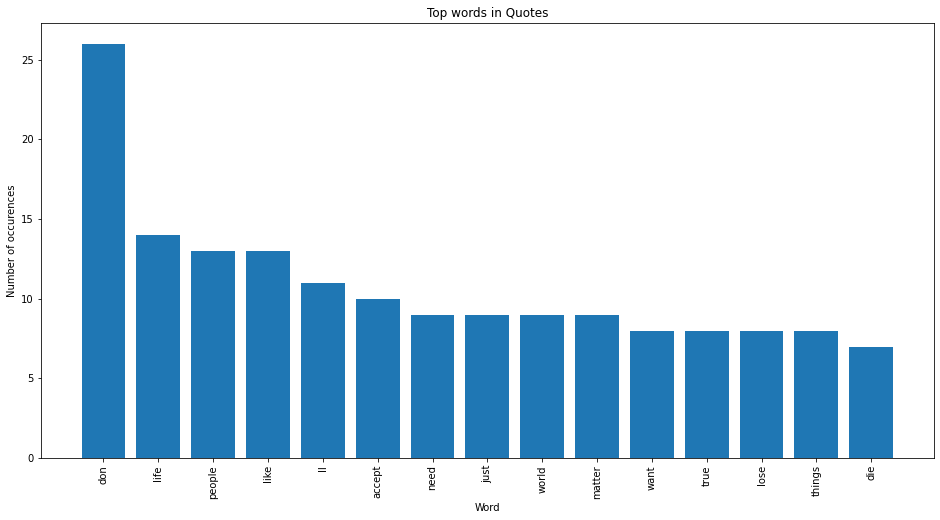

In [9]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=train_df['Quote'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Quotes');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = train_df['Quote'].values



In [12]:
print('Headline before vectorization: {}'.format(small_text_sample[12]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[12]))

Headline before vectorization: I’ll leave tomorrow’s problems to tomorrow’s me.
Headline after vectorization: 
  (0, 250)	1
  (0, 409)	2
  (0, 231)	1
  (0, 312)	1


In [20]:
n_topics = 5

In [21]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [22]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [23]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [24]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [25]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  don accept need want people true know die like life
Topic 2:  person good things bad like overcome don truth living peace
Topic 3:  ll heart make people wound pain lose outcome reject away
Topic 4:  matter world doesn just beautiful important place war begins justice
Topic 5:  life like ve chance gonna think hit comes moment time
